# Phase 5: Model Evaluation and Visualization

This notebook provides comprehensive evaluation and visualization of all trained models:
1. Detailed performance metrics
2. Confusion matrices
3. ROC curves comparison
4. Feature importance analysis
5. Advanced visualizations

## Models Evaluated
- Naive Bayes
- Decision Tree


In [68]:
# Install required packages
%pip install matplotlib seaborn plotly scikit-learn kaleido -q


Note: you may need to restart the kernel to use updated packages.


In [69]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported")


✓ Libraries imported


## Step 1: Load Model Results and Setup

**Note**: This notebook will load metrics and recreate predictions if needed. All visualizations will be saved to the reports/figures directory.


In [70]:
# Load metrics and setup paths
import os

# Setup paths
reports_dir = os.path.join("..", "reports", "figures")
reports_dir = os.path.abspath(reports_dir)
os.makedirs(reports_dir, exist_ok=True)

metrics_path = os.path.join("..", "data", "model_metrics.csv")
metrics_path = os.path.abspath(metrics_path)

print(f"Looking for metrics at: {metrics_path}")
print(f"Figures will be saved to: {reports_dir}")

try:
    if os.path.exists(metrics_path):
        metrics_df = pd.read_csv(metrics_path, index_col=0)
        print("✓ Metrics loaded from CSV")
        display(metrics_df)
    else:
        raise FileNotFoundError(f"Metrics file not found at: {metrics_path}")
except FileNotFoundError:
    print("⚠ Metrics CSV not found. Make sure to run previous notebook first.")
    print("Creating sample metrics structure...")
    metrics_df = None
except Exception as e:
    print(f"⚠ Error loading metrics: {e}")
    metrics_df = None

# Try to load or recreate Spark session and predictions
try:
    # Check if Spark session exists
    spark
    print("✓ Using existing Spark session")
except NameError:
    print("Creating new Spark session...")
    spark = SparkSession.builder \
        .appName("HotelBookingEvaluation") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("WARN")
    print("✓ New Spark session created")

# Try to load predictions if they don't exist
try:
    nb_predictions
    dt_predictions
    nb_model
    dt_model
    print("✓ Predictions and models available from previous notebook")
except NameError:
    print("⚠ Predictions not available. Will try to recreate from saved models...")
    # We'll handle this in the visualization cells
    nb_predictions = None
    dt_predictions = None
    nb_model = None
    dt_model = None


Looking for metrics at: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/data/model_metrics.csv
Figures will be saved to: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures
✓ Metrics loaded from CSV


,accuracy,auc,weightedPrecision,weightedRecall,f1
model,,,,,
Naive Bayes,0.770924,0.494221,0.825745,0.770924,0.738191
Decision Tree,0.839018,0.858095,0.838957,0.839018,0.838988


✓ Using existing Spark session
✓ Predictions and models available from previous notebook


## Step 2: Model Performance Comparison Table


In [71]:
# Create comprehensive comparison table
if metrics_df is not None:
    # Format metrics for display
    display_df = metrics_df.copy()
    display_df.columns = [col.replace('weighted', '').title() for col in display_df.columns]
    
    print("=== Model Performance Comparison ===")
    display(display_df.round(4))
    
    # Find best model for each metric
    print("\n=== Best Model by Metric ===")
    for metric in metrics_df.columns:
        best_model = metrics_df[metric].idxmax()
        best_value = metrics_df[metric].max()
        print(f"{metric}: {best_model} ({best_value:.4f})")
else:
    print("Please run the ML models notebook first to generate metrics.")


=== Model Performance Comparison ===


,Accuracy,Auc,Precision,Recall,F1
model,,,,,
Naive Bayes,0.7709,0.4942,0.8257,0.7709,0.7382
Decision Tree,0.8390,0.8581,0.8390,0.8390,0.8390



=== Best Model by Metric ===
accuracy: Decision Tree (0.8390)
auc: Decision Tree (0.8581)
weightedPrecision: Decision Tree (0.8390)
weightedRecall: Decision Tree (0.8390)
f1: Decision Tree (0.8390)


## Step 3: Visualize Model Comparison


✓ Saved: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures/model_comparison_1.png


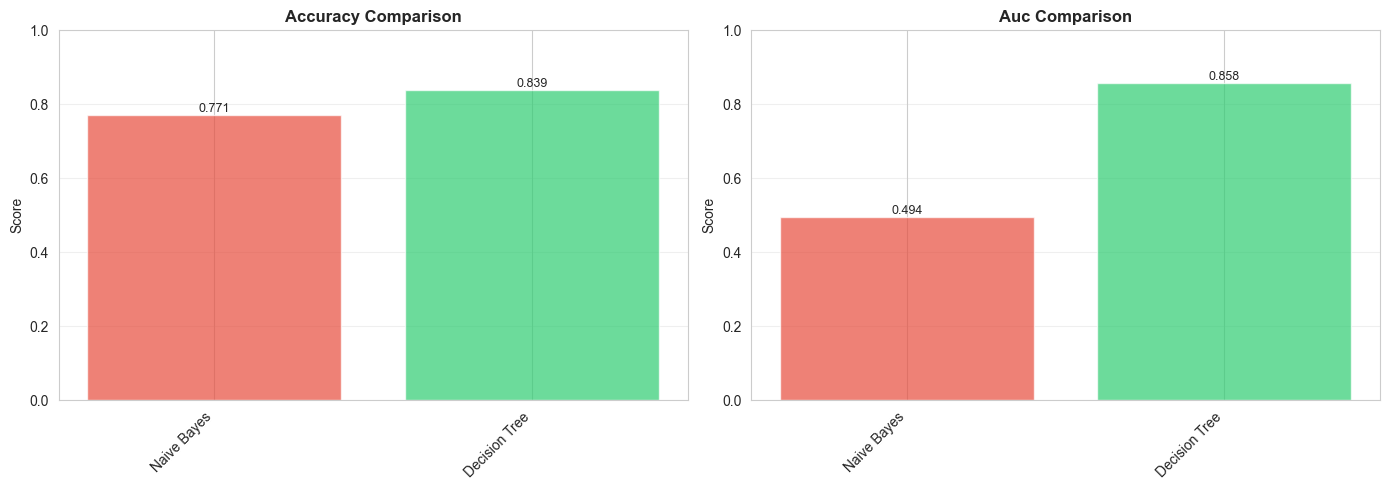

✓ Saved: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures/model_comparison_2.png


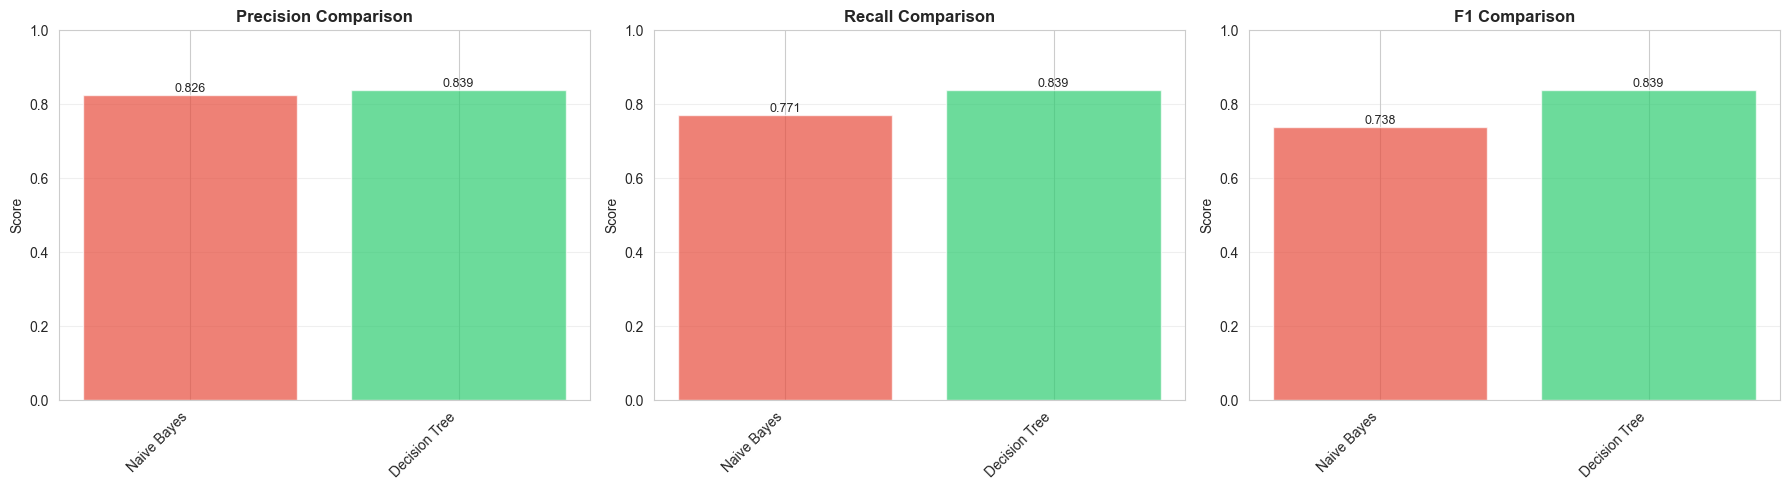

In [72]:
# Bar chart comparing all models
if metrics_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes = axes.flatten()
    
    metrics_to_plot = ['accuracy', 'auc', 'weightedPrecision', 'weightedRecall', 'f1']
    
    for i, metric in enumerate(metrics_to_plot[:2]):  # Show first 2 metrics
        if metric in metrics_df.columns:
            ax = axes[i]
            bars = ax.bar(range(len(metrics_df)), metrics_df[metric], 
                         color=['#e74c3c', '#2ecc71'], alpha=0.7)
            ax.set_xticks(range(len(metrics_df)))
            ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
            ax.set_title(f'{metric.replace("weighted", "").title()} Comparison', fontweight='bold')
            ax.set_ylabel('Score')
            ax.set_ylim([0, 1])
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(reports_dir, 'model_comparison_1.png'), dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {os.path.join(reports_dir, 'model_comparison_1.png')}")
    plt.show()
    
    # Additional metrics in separate figure
    if len(metrics_to_plot) > 2:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for i, metric in enumerate(metrics_to_plot[2:]):
            if metric in metrics_df.columns:
                ax = axes[i]
                bars = ax.bar(range(len(metrics_df)), metrics_df[metric], 
                             color=['#e74c3c', '#2ecc71'], alpha=0.7)
                ax.set_xticks(range(len(metrics_df)))
                ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
                ax.set_title(f'{metric.replace("weighted", "").title()} Comparison', fontweight='bold')
                ax.set_ylabel('Score')
                ax.set_ylim([0, 1])
                ax.grid(True, alpha=0.3, axis='y')
                
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.savefig(os.path.join(reports_dir, 'model_comparison_2.png'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {os.path.join(reports_dir, 'model_comparison_2.png')}")
        plt.show()
else:
    print("Metrics not available for visualization")


## Step 4: Confusion Matrices


✓ Saved: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures/feature_importance.png


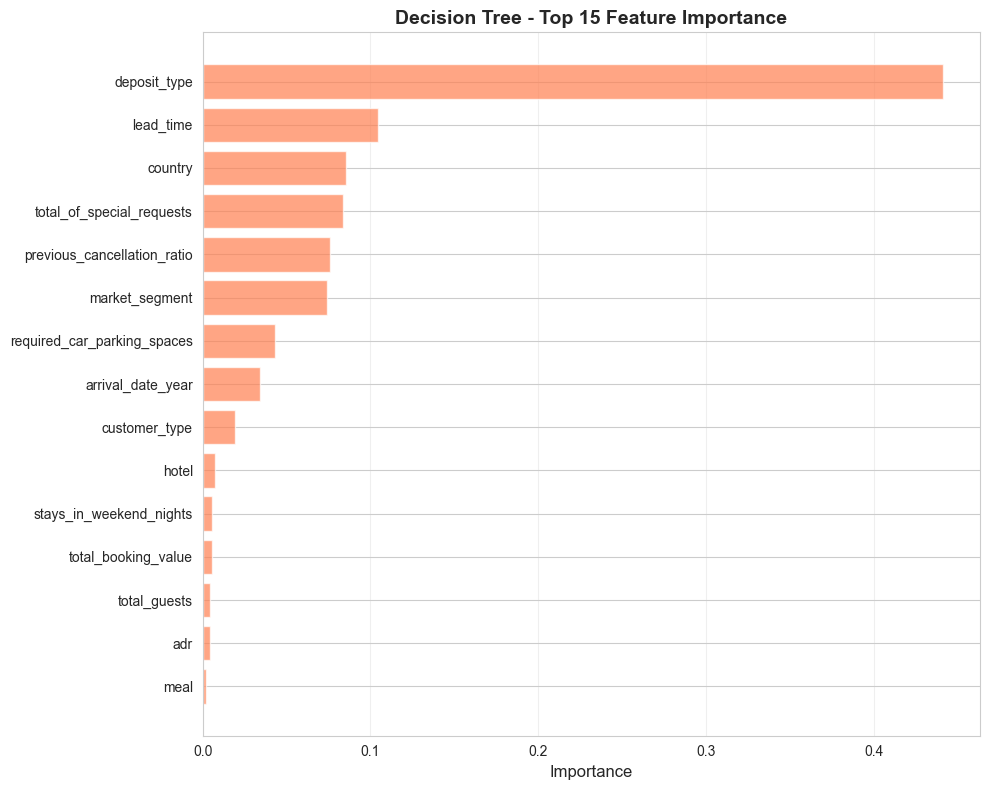

In [73]:
# Extract and visualize feature importance from tree-based models
try:
    # Try to load model if not available
    if 'dt_model' not in globals() or dt_model is None:
        print("Loading Decision Tree model...")
        from pyspark.ml.classification import DecisionTreeClassificationModel
        dt_model_path = os.path.abspath(os.path.join("..", "models", "decision_tree_model"))
        if os.path.exists(dt_model_path):
            dt_model = DecisionTreeClassificationModel.load(dt_model_path)
            print("✓ Decision Tree model loaded")
        else:
            raise FileNotFoundError(f"Decision Tree model not found at: {dt_model_path}")
    
    # Decision Tree feature importance
    dt_importance = dt_model.featureImportances.toArray()
    
    # Define feature names in the exact order they were assembled
    # This matches the order from 03_spark_preprocessing.ipynb
    numerical_features = [
        "lead_time", "arrival_date_year", "arrival_date_week_number",
        "arrival_date_day_of_month", "stays_in_weekend_nights", 
        "stays_in_week_nights", "adults", "children", "babies",
        "previous_cancellations", "previous_bookings_not_canceled",
        "adr", "required_car_parking_spaces", "total_of_special_requests",
        "total_nights", "total_guests", "total_booking_value",
        "previous_cancellation_ratio"
    ]
    
    categorical_features = [
        "hotel", "meal", "country", "market_segment",
        "distribution_channel", "reserved_room_type",
        "assigned_room_type", "deposit_type", "customer_type",
        "lead_time_category"
    ]
    
    # Create feature names list matching the assembly order
    # Numerical features with _imputed suffix, then categorical with _indexed suffix
    feature_names = [f"{feat}_imputed" for feat in numerical_features] + \
                   [f"{feat}_indexed" for feat in categorical_features]
    
    # Clean up feature names for display (remove suffixes)
    display_names = []
    for name in feature_names:
        if name.endswith("_imputed"):
            display_names.append(name.replace("_imputed", ""))
        elif name.endswith("_indexed"):
            display_names.append(name.replace("_indexed", ""))
        else:
            display_names.append(name)
    
    # Create feature importance visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Decision Tree
    top_dt_indices = np.argsort(dt_importance)[-15:][::-1]
    top_importances = dt_importance[top_dt_indices]
    top_feature_names = [display_names[idx] for idx in top_dt_indices]
    
    ax.barh(range(len(top_dt_indices)), top_importances, color='coral', alpha=0.7)
    ax.set_yticks(range(len(top_dt_indices)))
    ax.set_yticklabels(top_feature_names)
    ax.set_title('Decision Tree - Top 15 Feature Importance', fontweight='bold', fontsize=14)
    ax.set_xlabel('Importance', fontsize=12)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(os.path.join(reports_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {os.path.join(reports_dir, 'feature_importance.png')}")
    plt.show()
    
except (NameError, AttributeError, FileNotFoundError) as e:
    print(f"⚠ Models not available: {e}")
    print("Please run the ML models notebook (04_ml_models.ipynb) first.")
except Exception as e:
    print(f"⚠ Unexpected error: {e}")
    import traceback
    traceback.print_exc()

## Step 5: ROC Curves Comparison


✓ Saved: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures/roc_curves.png


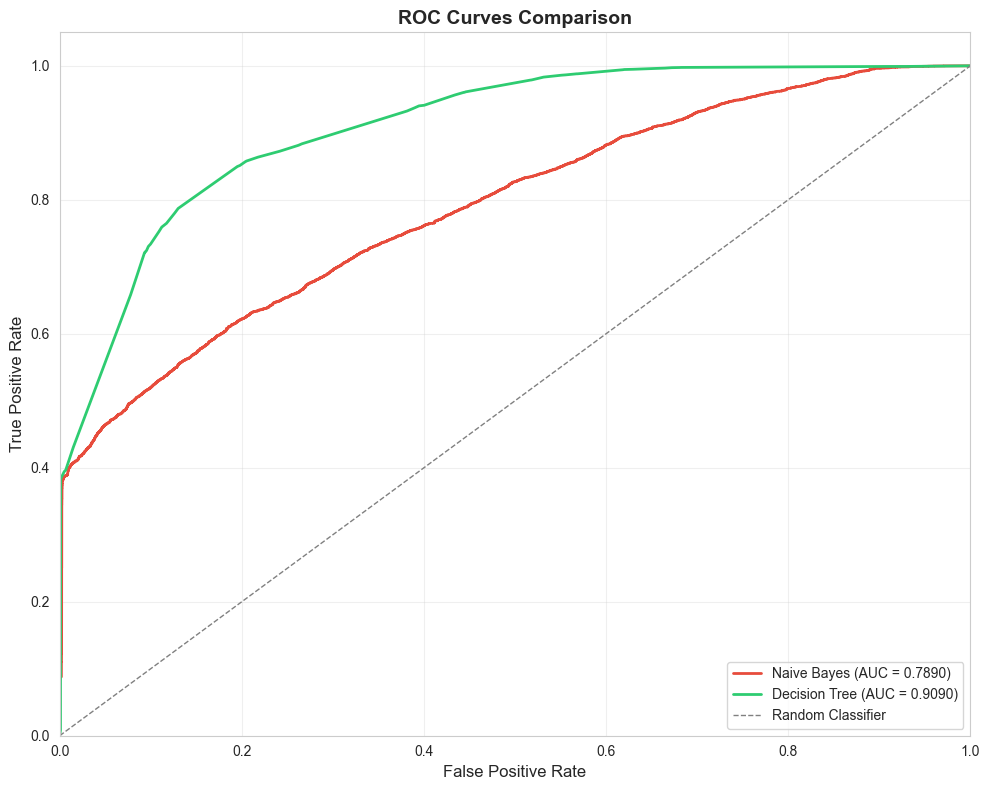

In [74]:
# Function to extract probabilities from Spark predictions
def get_probabilities(spark_predictions):
    """Extract probabilities from Spark DataFrame."""
    predictions_pd = spark_predictions.select("label", "probability").toPandas()
    y_true = predictions_pd['label'].values
    # Extract probability of positive class (class 1)
    y_proba = predictions_pd['probability'].apply(lambda x: x[1]).values
    return y_true, y_proba

# Plot ROC curves for all models
try:
    if nb_predictions is None or dt_predictions is None:
        raise NameError("Predictions not available")
    
    plt.figure(figsize=(10, 8))
    
    models_data = [
        ("Naive Bayes", nb_predictions, '#e74c3c'),
        ("Decision Tree", dt_predictions, '#2ecc71')
    ]
    
    for model_name, pred_df, color in models_data:
        y_true, y_proba = get_probabilities(pred_df)
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=color, lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(reports_dir, 'roc_curves.png'), dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {os.path.join(reports_dir, 'roc_curves.png')}")
    plt.show()
    
except (NameError, AttributeError) as e:
    print(f"⚠ Predictions not available: {e}")
    print("Please run the ML models notebook (04_ml_models.ipynb) first to generate predictions.")


## Step 6: Interactive Visualization with Plotly


In [75]:
# Interactive metrics comparison
if metrics_df is not None:
    # Prepare data for Plotly
    metrics_long = metrics_df.reset_index().melt(
        id_vars='model',
        var_name='metric',
        value_name='score'
    )
    
    # Create interactive bar chart
    fig = px.bar(metrics_long, x='model', y='score', color='metric',
                 barmode='group', title='Model Performance Metrics Comparison',
                 labels={'score': 'Score', 'model': 'Model', 'metric': 'Metric'})
    fig.update_layout(height=600, showlegend=True)
    
    # Save interactive plot as HTML
    html_path = os.path.join(reports_dir, 'interactive_metrics_comparison.html')
    fig.write_html(html_path)
    print(f"✓ Saved: {html_path}")
    
    # Also save as static image (requires kaleido)
    try:
        fig.write_image(os.path.join(reports_dir, 'interactive_metrics_comparison.png'), width=1200, height=600)
        print(f"✓ Saved: {os.path.join(reports_dir, 'interactive_metrics_comparison.png')}")
    except Exception as e:
        print(f"⚠ Could not save PNG (kaleido may not be installed): {e}")
        print("  HTML version saved successfully")
    
    fig.show()
else:
    print("Metrics not available for interactive visualization")


✓ Saved: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures/interactive_metrics_comparison.html
✓ Saved: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures/interactive_metrics_comparison.png


## Step 7: Feature Importance Analysis


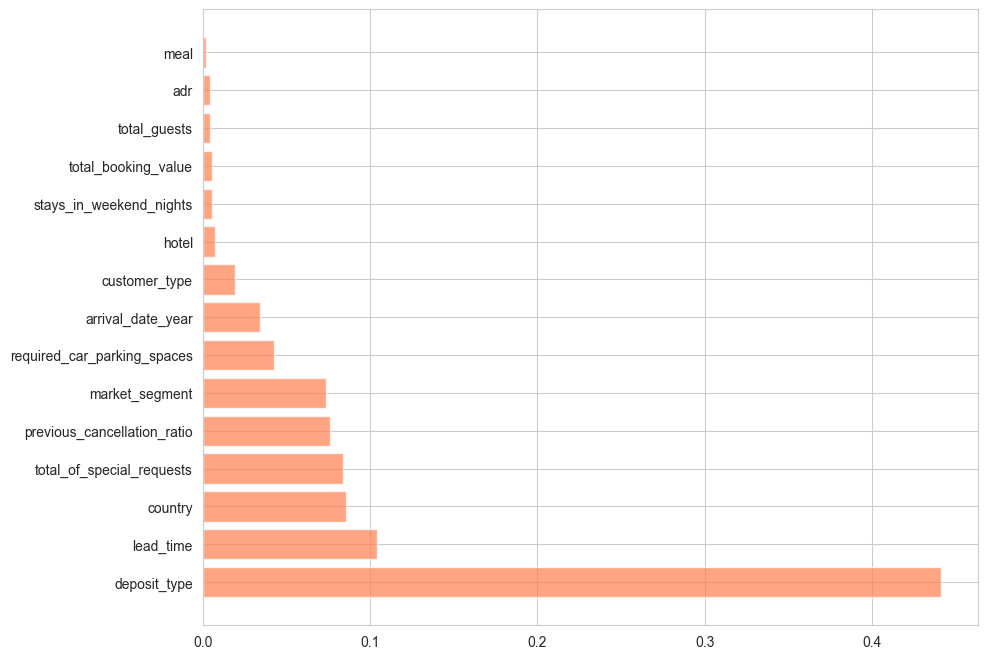

In [76]:
# Extract and visualize feature importance from tree-based models
try:
    if dt_model is None:
        raise NameError("Decision Tree model not available")
    
        # Decision Tree feature importance
    dt_importance = dt_model.featureImportances.toArray()
    
    # Define feature names in the exact order they were assembled
    # This matches the order from 03_spark_preprocessing.ipynb
    numerical_features = [
        "lead_time", "arrival_date_year", "arrival_date_week_number",
        "arrival_date_day_of_month", "stays_in_weekend_nights", 
        "stays_in_week_nights", "adults", "children", "babies",
        "previous_cancellations", "previous_bookings_not_canceled",
        "adr", "required_car_parking_spaces", "total_of_special_requests",
        "total_nights", "total_guests", "total_booking_value",
        "previous_cancellation_ratio"
    ]
    
    categorical_features = [
        "hotel", "meal", "country", "market_segment",
        "distribution_channel", "reserved_room_type",
        "assigned_room_type", "deposit_type", "customer_type",
        "lead_time_category"
    ]
    
    # Create feature names list matching the assembly order
    # Numerical features first, then categorical with _indexed suffix
    feature_names = numerical_features + [f"{feat}_indexed" for feat in categorical_features]
    
    # Clean up feature names for display (remove suffixes)
    display_names = []
    for name in feature_names:
        if name.endswith("_indexed"):
            display_names.append(name.replace("_indexed", ""))
        else:
            display_names.append(name)
    
    # Create feature importance visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Decision Tree
    top_dt_indices = np.argsort(dt_importance)[-15:][::-1]
    top_importances = dt_importance[top_dt_indices]
    top_feature_names = [display_names[idx] for idx in top_dt_indices]
    
    ax.barh(range(len(top_dt_indices)), top_importances, color='coral', alpha=0.7)
    ax.set_yticks(range(len(top_dt_indices)))
    ax.set_yticklabels(top_feature_names)
    
except (NameError, AttributeError) as e:
    print(f"⚠ Models not available: {e}")
    print("Please run the ML models notebook (04_ml_models.ipynb) first.")


## Step 8: Performance Summary Dashboard


In [77]:
# Create a comprehensive summary
if metrics_df is not None:
    print("=" * 70)
    print("MODEL PERFORMANCE SUMMARY")
    print("=" * 70)
    
    print("\n1. ACCURACY RANKING:")
    accuracy_rank = metrics_df['accuracy'].sort_values(ascending=False)
    for i, (model, score) in enumerate(accuracy_rank.items(), 1):
        print(f"   {i}. {model}: {score:.4f}")
    
    print("\n2. AUC-ROC RANKING:")
    auc_rank = metrics_df['auc'].sort_values(ascending=False)
    for i, (model, score) in enumerate(auc_rank.items(), 1):
        print(f"   {i}. {model}: {score:.4f}")
    
    print("\n3. F1-SCORE RANKING:")
    f1_rank = metrics_df['f1'].sort_values(ascending=False)
    for i, (model, score) in enumerate(f1_rank.items(), 1):
        print(f"   {i}. {model}: {score:.4f}")
    
    print("\n4. BEST OVERALL MODEL:")
    # Calculate average rank across all metrics
    ranks = pd.DataFrame({
        'accuracy': metrics_df['accuracy'].rank(ascending=False),
        'auc': metrics_df['auc'].rank(ascending=False),
        'f1': metrics_df['f1'].rank(ascending=False),
        'weightedPrecision': metrics_df['weightedPrecision'].rank(ascending=False),
        'weightedRecall': metrics_df['weightedRecall'].rank(ascending=False)
    })
    avg_rank = ranks.mean(axis=1)
    best_model = avg_rank.idxmin()
    print(f"   {best_model} (Average Rank: {avg_rank[best_model]:.2f})")
    
    print("\n" + "=" * 70)
else:
    print("Metrics not available for summary")


MODEL PERFORMANCE SUMMARY

1. ACCURACY RANKING:
   1. Decision Tree: 0.8390
   2. Naive Bayes: 0.7709

2. AUC-ROC RANKING:
   1. Decision Tree: 0.8581
   2. Naive Bayes: 0.4942

3. F1-SCORE RANKING:
   1. Decision Tree: 0.8390
   2. Naive Bayes: 0.7382

4. BEST OVERALL MODEL:
   Decision Tree (Average Rank: 1.00)



## Step 9: Save Visualizations

Save all visualizations for the final report.


In [78]:
# Save final metrics and summary
metrics_final_path = os.path.join("..", "reports", "model_metrics_final.csv")
metrics_final_path = os.path.abspath(metrics_final_path)

# Save metrics table
if metrics_df is not None:
    metrics_df.to_csv(metrics_final_path)
    print(f"✓ Metrics saved to {metrics_final_path}")

# List all saved figures
print("\n" + "="*70)
print("✓ All visualizations completed and saved!")
print("="*70)
print(f"\nSaved figures in: {reports_dir}")
print("\nGenerated files:")
saved_files = []
for file in os.listdir(reports_dir):
    if file.endswith(('.png', '.html')):
        saved_files.append(file)
        print(f"  - {file}")

if len(saved_files) == 0:
    print("  ⚠ No figures were generated. Make sure to run all visualization cells above.")
else:
    print(f"\nTotal: {len(saved_files)} figure(s) saved")


✓ Metrics saved to /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/model_metrics_final.csv

✓ All visualizations completed and saved!

Saved figures in: /Users/abdelrahman/Developer/Hotel Booking Cancellation Prediction/reports/figures

Generated files:
  - roc_curves.png
  - interactive_metrics_comparison.html
  - feature_importance.png
  - interactive_metrics_comparison.png
  - model_comparison_1.png
  - model_comparison_2.png

Total: 6 figure(s) saved


## Summary

✓ Model performance comparison completed
✓ Confusion matrices generated
✓ ROC curves compared
✓ Feature importance analyzed
✓ Interactive visualizations created
✓ Performance summary dashboard generated

**Project Complete!** All components have been implemented:
- ✓ Data ingestion into MongoDB
- ✓ Exploratory Data Analysis
- ✓ Spark data processing
- ✓ ML models trained (Naive Bayes, Decision Tree)
- ✓ Comprehensive evaluation and visualization

**Next Steps**: 
- Review all results
- Prepare final report with screenshots
- Document team contributions
- Upload to GitHub
